# Building Belief Networks with `pgmpy`

In this notebook we will use the [`pgmpy` python package](http://pgmpy.org) to build belief networks.  See the website for detailed installation instructions, but basically:

```bash
$ pip3 install -r requirements.txt
$ pip3 install pgmpy
```

where the `requirements.txt` file (obtained from the github source [here](https://github.com/pgmpy/pgmpy/blob/dev/requirements.txt)) is a list of the `pgmpy` package dependencies that must also be installed.

See [the docs](http://pgmpy.org) for reference or [these notebooks](https://github.com/pgmpy/pgmpy_notebook/tree/master/notebooks) and [these examples](https://github.com/pgmpy/pgmpy/tree/dev/examples) from the `pgmpy` github site (although several aren't finished).  We will cover the basics here.

## Example 1: Inspector Clouseau

Here we re-do the Inspector Clouseau example from Barber, but this time by constructing a belief network.

>**Barber Example 1.3 (Inspector Clouseau)**
>
>Inspector Clouseau arrives at the scene of a crime. The victim lies dead in the room and the inspector quickly ﬁnds the murder weapon, a Knife (`K`). The Butler (`B`) and Maid (`M`) are his main suspects. The inspector has a prior belief of 0.8 that the Butler is the murderer, and a prior belief of 0.2 that the Maid is the murderer. These probabilities are independent in the sense that $p(B, M) = p(B)p(M)$. (It is possible that both the Butler and the Maid murdered the victim or neither). The inspector’s *prior* criminal knowledge can be formulated mathematically as follows.

(Here we use short-hand notation, e.g. $p(B)$ means the (*a priori*) probability that the butler is the murder, $p(K|B,\lnot M$ means the probability that the knife was used given that the butler was the murder and the maid was not.)
>
>$$
\begin{align}
p(B) & = 0.6 \\
p(M) & = 0.2 \\
p(M, B) & = p(M)p(B)
\end{align}
$$
>
>$$
\begin{align}
p(K | \lnot B, \lnot M) & = 0.3 \\
p(K | \lnot B, M) & = 0.2 \\
p(K | B, \lnot M) & = 0.6 \\
p(K | B, M) & = 0.1
\end{align}
$$
>
>Assuming the knife is the murder weapon, what is the probability that the Butler is the murderer?

We can solve this by creating a Bayesian network using the `pgmpy` package.  First, we import it:

In [1]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

### Build Up Network

In `pgmpy`, a belief network is specified by variables and their conditional probabilities. To build the model, you describe the structure of network by defining nodes and links in a directed graph, and then assign the conditional probabilities (or priors) for each variable.

In [2]:
model = BayesianModel([('B', 'K'), ('M', 'K')])

# define p(B) and p(M) 
# variable_card is cardinality = 2 for true|false
# values are defined in numeric order p(x_i = [false, true]), ie  [0, 1]
priorB = TabularCPD(variable='B', variable_card=2, values=[[0.4, 0.6]])
priorM = TabularCPD(variable='M', variable_card=2, values=[[0.8, 0.2]])

# define p(K|B,M)
# Variables cycle in numerical order of evidence values,
# ie BM = 00, 01, 10, 11 for each value of K.
cpdK = TabularCPD(variable='K', variable_card=2, 
    evidence=['B', 'M'], evidence_card=[2, 2],
    values=[[0.7, 0.8, 0.4, 0.9], 
            [0.3, 0.2, 0.6, 0.1]])

# add probabilities to model
model.add_cpds(priorB, priorM, cpdK)

The `check_model` function check structure and values consistency. For example, it will give an error if the probabilities don't sum to one.

In [3]:
model.check_model()

True

#### Two methods for plotting

1. Using [`networkx`](https://networkx.github.io/documentation/networkx-1.9/index.html) and [pyplot](https://matplotlib.org/api/pyplot_api.html) packages.  This plots directly from model.

In [4]:
# TODO: Improve the layout and style
import networkx as nx
import matplotlib.pyplot as plt
nx.draw(model, with_labels=True)
plt.show()

ImportError: cannot import name _path

2. Use the [graphviz](https://github.com/xflr6/graphviz) package, which produces a nice layout by default, but you have to define the graph separately.

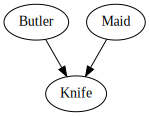

In [5]:
# TODO: Can we plot with graphviz using model directly?

from graphviz import Digraph

dot = Digraph()
dot.node('B', 'Butler') # variable name, label
dot.node('M', 'Maid')
dot.node('K', 'Knife')
dot.edges(['BK', 'MK'])
# render inline
dot

# Or print to a pdf:
#print(dot.source)
#dot.render("Clouseau", view=True)

#### Displaying the conditional probability tables

We can also display the conditional probability tables, which we can verify match the definitions above.  Note that in `pgmpy`, the rows are the states of the variable and and colums are the states of evidence variables.  $P(K|B,M)$ is shown below.  Note that the variables of the CDF are in the rows and the conditioned variables are in the columns.

In [6]:
print(model.get_cpds('K'))

+-----+-----+-----+-----+-----+
| B   | B_0 | B_0 | B_1 | B_1 |
+-----+-----+-----+-----+-----+
| M   | M_0 | M_1 | M_0 | M_1 |
+-----+-----+-----+-----+-----+
| K_0 | 0.7 | 0.8 | 0.4 | 0.9 |
+-----+-----+-----+-----+-----+
| K_1 | 0.3 | 0.2 | 0.6 | 0.1 |
+-----+-----+-----+-----+-----+


We can also print the probabilities for the other variables.  Here there are no conditioned variables.

In [16]:
print(model.get_cpds('B'))

+-----+-----+
| B_0 | 0.4 |
+-----+-----+
| B_1 | 0.6 |
+-----+-----+


In [17]:
print(model.get_cpds('M'))

+-----+-----+
| M_0 | 0.8 |
+-----+-----+
| M_1 | 0.2 |
+-----+-----+


### Inference in Belief Networks

From Barber, we can solve for a query pdf such as $p(B|K)$ using variable elimination as follows:

$$
\begin{align}
p(B|K) & = \sum_{m} p(B,m|K) \\
       & = \sum_{m} \frac{p(B,m,K)}{p(K)} \\
       & = \frac{p(B) \sum_{m} p(K|B,m)p(m)}{\sum_{b} p(b) \sum_{m} p(K|b,m) p(m)}
\end{align}
$$

Note how the summation variables are lowercase versions of the random variables to keep them distinct.  The capital variables are set from $p(B|K)$, but the summation variables are $b$ and $m$, which sum over the domains of $B$ and $M$ (which here are the same).  Filling in the values above,  we get

$$
\begin{align}
       & = \dfrac{0.6 \times (0.2 \times 0.1 + 0.8 \times 0.6)}{0.6 \times (0.2 \times 0.1 + 0.8 \times 0.6) + 0.4 \times (0.2 \times 0.2 + 0.8 \times 0.3)} \\
       & \approx 0.73
\end{align}
$$

To solve for $p(B|K = \textsf{true})$ using variable elimination with `pgmpy`:

In [8]:
from pgmpy.inference import VariableElimination

inference = VariableElimination(model)
print(inference.query(['B'], evidence={'K' : 1}) ['B'])

+-----+----------+
| B   |   phi(B) |
|-----+----------|
| B_0 |   0.2718 |
| B_1 |   0.7282 |
+-----+----------+


We can see that the result is return as a dictionary with a single key 'B':

In [9]:
inference.query(['B'], evidence={'K' : 1})

{'B': <DiscreteFactor representing phi(B:2) at 0x18bd2978L>}

We can easily compute the probability for the other suspect $p(M|K)$

In [10]:
print(inference.query(['M'], evidence={'K' : 1}) ['M'])

+-----+----------+
| M   |   phi(M) |
|-----+----------|
| M_0 |   0.9320 |
| M_1 |   0.0680 |
+-----+----------+


We can also add evidence. For example if we know that the maid could not have been present, then $p(B|K=\textsf{true}, M=\textsf{false})$

In [21]:
print(inference.query(['B'], evidence={'K' : 1, 'M' : 0})['B'])

+-----+----------+
| B   |   phi(B) |
+=====+==========+
| B_0 |   0.2500 |
+-----+----------+
| B_1 |   0.7500 |
+-----+----------+


Which seems odd.  How can the probability that the butler is the murder go *down* when we learn that the maid could not have been present?  We can check the equations.

$$
\begin{align}
p(B | K,M) & = \frac{p(B,M,K)}{p(K, M)} \\
       & = \frac{p(K | B,M) p(B) P(M)}{p(M)\sum_{b} p(K|b,M) p(b)}
\end{align}
$$



First we need to know the basics of defining and manipulating probability distributions in `pgmpy`.

In [22]:
from pgmpy.factors.discrete import DiscreteFactor
# DiscreteFactor(variables, cardinality, values)
phi1 = DiscreteFactor(['x1'], [2], [0.4, 0.6])
print(phi1)

+------+-----------+
| x1   |   phi(x1) |
+======+===========+
| x1_0 |    0.4000 |
+------+-----------+
| x1_1 |    0.6000 |
+------+-----------+


In [23]:
phi2 = DiscreteFactor(['x2'], [2], [0.3, 0.7])
print(phi2)

+------+-----------+
| x2   |   phi(x2) |
+======+===========+
| x2_0 |    0.3000 |
+------+-----------+
| x2_1 |    0.7000 |
+------+-----------+


In [24]:
phi3=phi1.product(phi2, inplace=False) # inplace means make copy, don't overwrite
print(phi3)

+------+------+--------------+
| x1   | x2   |   phi(x1,x2) |
+======+======+==============+
| x1_0 | x2_0 |       0.1200 |
+------+------+--------------+
| x1_0 | x2_1 |       0.2800 |
+------+------+--------------+
| x1_1 | x2_0 |       0.1800 |
+------+------+--------------+
| x1_1 | x2_1 |       0.4200 |
+------+------+--------------+


/anaconda3/lib/python3.6/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:586: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi.values = phi.values[slice_]


In [25]:
from pgmpy.factors.discrete import TabularCPD
px1 = TabularCPD('x1', 2, [[0.4, 0.6]])
#Or with keywords:
#px1 = TabularCPD(variable='x1', variable_card=2, values=[[0.4, 0.6]])
print(px1)

+------+-----+
| x1_0 | 0.4 |
+------+-----+
| x1_1 | 0.6 |
+------+-----+


In [26]:
px2 = TabularCPD('x2', 2, [[0.3, 0.7]])
print(px2)

+------+-----+
| x2_0 | 0.3 |
+------+-----+
| x2_1 | 0.7 |
+------+-----+


In [ ]:
print(px1.product(px2, inplace=False))

So we can compute the product of the distributions in the numerator, to get the unnormalized values of $p(B | K,M)$

In [27]:
print(model.get_cpds('K'))
print(model.get_cpds('B'))
print(model.get_cpds('M'))

+-----+-----+-----+-----+-----+
| B   | B_0 | B_0 | B_1 | B_1 |
+-----+-----+-----+-----+-----+
| M   | M_0 | M_1 | M_0 | M_1 |
+-----+-----+-----+-----+-----+
| K_0 | 0.7 | 0.8 | 0.4 | 0.9 |
+-----+-----+-----+-----+-----+
| K_1 | 0.3 | 0.2 | 0.6 | 0.1 |
+-----+-----+-----+-----+-----+
+-----+-----+
| B_0 | 0.4 |
+-----+-----+
| B_1 | 0.6 |
+-----+-----+
+-----+-----+
| M_0 | 0.8 |
+-----+-----+
| M_1 | 0.2 |
+-----+-----+


In [28]:
pB = model.get_cpds('B')
pM = model.get_cpds('M')
print(pB.product(pM, inplace=False))

+-----+---------------------+---------------------+
| M   | M_0                 | M_1                 |
+-----+---------------------+---------------------+
| B_0 | 0.32000000000000006 | 0.08000000000000002 |
+-----+---------------------+---------------------+
| B_1 | 0.48                | 0.12                |
+-----+---------------------+---------------------+


In [29]:
pKgBM = model.get_cpds('K')
print(pKgBM.product(pB, inplace=False))

+-----+---------------------+---------------------+------+------+
| B   | B_0                 | B_0                 | B_1  | B_1  |
+-----+---------------------+---------------------+------+------+
| M   | M_0                 | M_1                 | M_0  | M_1  |
+-----+---------------------+---------------------+------+------+
| K_0 | 0.27999999999999997 | 0.32000000000000006 | 0.24 | 0.54 |
+-----+---------------------+---------------------+------+------+
| K_1 | 0.12                | 0.08000000000000002 | 0.36 | 0.06 |
+-----+---------------------+---------------------+------+------+


In [30]:
print(pKgBM.product(pB, inplace=False).product(pM, inplace=False))

+-----+---------------------+----------------------+-------+---------------------+
| B   | B_0                 | B_0                  | B_1   | B_1                 |
+-----+---------------------+----------------------+-------+---------------------+
| M   | M_0                 | M_1                  | M_0   | M_1                 |
+-----+---------------------+----------------------+-------+---------------------+
| K_0 | 0.22399999999999998 | 0.06400000000000002  | 0.192 | 0.10800000000000001 |
+-----+---------------------+----------------------+-------+---------------------+
| K_1 | 0.096               | 0.016000000000000004 | 0.288 | 0.012               |
+-----+---------------------+----------------------+-------+---------------------+


The probability that neither of the suspects is the murderer can be computed by computing $p(B, M | K)$.  First we derive the theoretical solution using variable elimination.

$$
\begin{align}
p(B,M|K) & = \frac{p(B,M,K)}{p(K)} \\
&= \frac{p(K|B,M)P(B)P(M)}{\sum_{b,m} p(K|b,m)P(b)P(m)}
\end{align}
$$

So, all we have to do is compute the numerator, which we can do directly from the model, and normalize it.  What we want to do get the product of the three distributions in the numerator, and then normalize the result.

In [ ]:
model.get_cpds('K').values

In [ ]:
print(model.get_cpds('K'))

In [ ]:
pKgBM = model.get_cpds('K').values
for b in [1, 2]:
    for m in [1, 2]:
        for k in [1, 2]:
            pBMgK[b][m][k] = 

In [31]:
inference.query(['B', 'M'], evidence={'K' : 1})

{'B': <DiscreteFactor representing phi(B:2) at 0x1a2773a2e8>,
 'M': <DiscreteFactor representing phi(M:2) at 0x1a2773a748>}

In [32]:
# This does not do what we want, which is to 
# compute the joint probability p(B, M | K)
inference.query(['B', 'M'], evidence={'K' : 1})['B']

<DiscreteFactor representing phi(B:2) at 0x1a2773a710>

In [33]:
# TODO: How do we print a probability table from a dictionary?
print(inference.query(['B', 'M'], evidence={'K' : 1})['B'])
print(inference.query(['B', 'M'], evidence={'K' : 1})['M'])

+-----+----------+
| B   |   phi(B) |
+=====+==========+
| B_0 |   0.2718 |
+-----+----------+
| B_1 |   0.7282 |
+-----+----------+
+-----+----------+
| M   |   phi(M) |
+=====+==========+
| M_0 |   0.9320 |
+-----+----------+
| M_1 |   0.0680 |
+-----+----------+


### Explaining away

Here we illustrate the concept of *explaining away* with the wet grass example.